<a href="https://colab.research.google.com/github/GodaBac/BachelorThesis/blob/main/SARIMA/SARIMA_with_differenced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pmdarima import auto_arima

Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
from datetime import datetime

input_file_path = '/content/drive/MyDrive/Bakalauras/duomenys.csv'

# Open the input CSV file
with open(input_file_path, 'r') as input_file:
    reader = csv.reader(input_file)

    value_names = next(reader)

    # Create an empty list to store the updated rows
    updated_rows = []

    # Loop through each row in the input file
    for row in reader:
         # Try to parse the date string as a datetime object
        try:
            date_str = row[0]
            date_obj = datetime.strptime(date_str, '%d-%m-%Y')
        except ValueError:
            # If the date string is not in the expected format, skip this row
            continue

        # Format the date object as a string in the new format
        new_date_str = date_obj.strftime('%Y-%m-%d')

        # Update the date value in the row
        row[0] = new_date_str
        # Append the updated row to the list of updated rows
        updated_rows.append(row)

# Convert the list of updated rows to a dataframe
df = pd.DataFrame(updated_rows, columns=value_names)

data differencing

In [ ]:
# Convert the date column to a datetime object
df['DT'] = pd.to_datetime(df['DT'], format='%Y-%m-%d')

# Set the date column as the index of the dataframe
df.set_index('DT', inplace=True)
df['ANTAL_01'] = df['ANTAL_01'].astype(int)
df = df.iloc[::-1]

<Axes: xlabel='DT'>

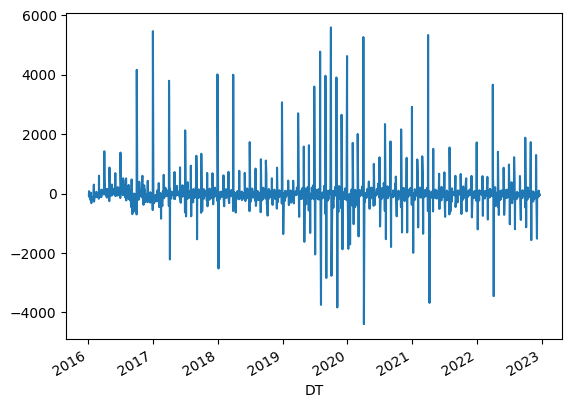

In [ ]:
df_copy = df
df_copy['ANTAL_01'] = df_copy['ANTAL_01'].astype(float) - df_copy['ANTAL_01'].astype(float).shift(1)
df_copy['ANTAL_01'].dropna().plot()

In [ ]:
#training and test
training = df_copy.dropna().iloc[:-16,:]
test = df_copy.dropna().iloc[-16:, :]

SARIMA model

In [ ]:
#SARIMA model
# Seasonal - fit stepwise auto-ARIMA
smodel = auto_arima(training, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=5,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=6.39 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=29178.466, Time=0.22 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=28674.858, Time=2.70 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=3.37 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=29176.473, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=29174.571, Time=0.39 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=28491.545, Time=6.88 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=5.33 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=3.30 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=28492.205, Time=4.28 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=28493.505, Time=3.57 sec
 ARIMA(1,0,1)(2,1,0)[5] intercept   : AIC=inf, Time=9.11 sec
 ARIMA(0,0,1)(2,1,0)[5] intercept   : AIC=28491.614, Time=3.01 sec
 ARIMA(2,0,1)(2,1,0)[5] intercept   : AIC=inf, Time=10.32 sec
 ARIMA(1,0,0)(2,1,0)[5]             : AIC=28489.545, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1801
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 5)   Log Likelihood              -14240.773
Date:                           Tue, 02 May 2023   AIC                          28489.545
Time:                                   17:03:24   BIC                          28511.518
Sample:                                        0   HQIC                         28497.657
                                          - 1801                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0385      0.029      1.316      0.188      -0.019       0.096
ar.S.L5       -0.6482      0.011    -57.487      0.000      -0.670      -0.626
ar.S.L10      -0.3125      0.012    -26.090      0.000      -0.336      -0.289
sigma2      4.512e+05   4552.949     99.104      0.000    4.42e+05     4.6e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             32930.44
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             1.74
Prob(H) (two-sided):                  0.30   Kurtosis:                        23.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(training, order=(1,0,0), seasonal_order=(2,1,0,5))
model_fit = model.fit()
yhat = model_fit.forecast()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
#predictions
predictions = pd.Series(smodel.predict(n_periods = len(test)))
predictions.index = test.index
predictions[:5]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


DT
2022-11-30   -140.454658
2022-12-01    -71.414431
2022-12-02     34.682313
2022-12-05   -144.810547
2022-12-06    -53.933645
dtype: float64

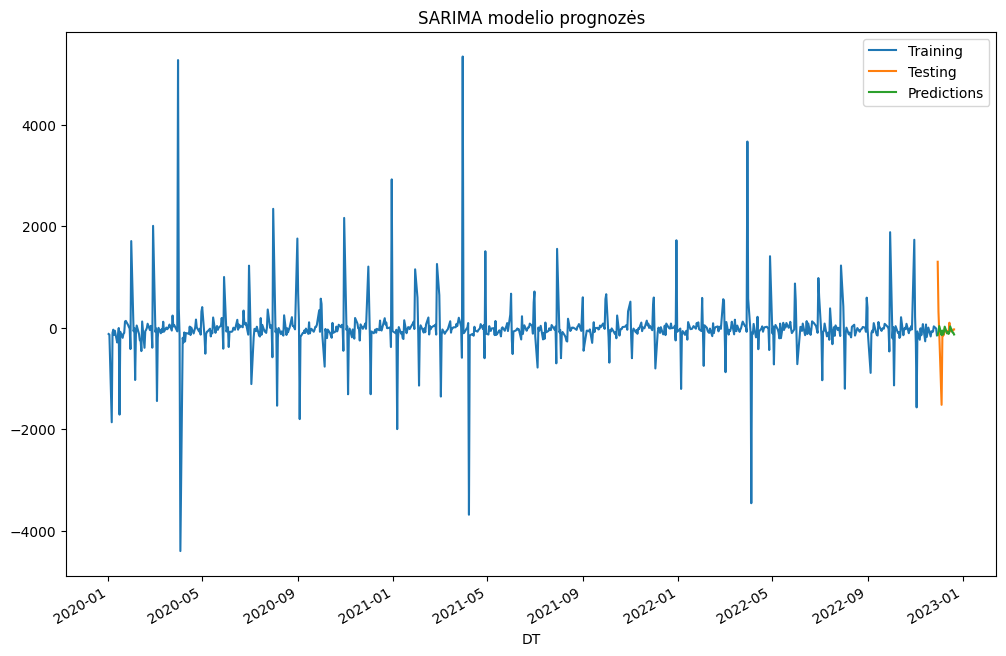

In [ ]:
#Visualization
import matplotlib.pyplot as plt
training['ANTAL_01']['2020-01-01':].plot(figsize=(12, 8), label='Training')
test['ANTAL_01'].plot(label='Testing')
predictions.plot(label='Predictions')
plt.title('SARIMA modelio prognozės')
plt.legend()

In [ ]:
predictions.head()

DT
2022-11-30   -140.454658
2022-12-01    -71.414431
2022-12-02     34.682313
2022-12-05   -144.810547
2022-12-06    -53.933645
dtype: float64

In [ ]:
last_values = df.iloc[:-16,:]
last_value = last_values[-1:]
last_value

,ANTAL_01
DT,
2022-11-29,30906


In [ ]:
original_preds= []

In [ ]:
for pred in predictions:
    pred_value = last_value + pred
    original_preds.append(pred_value)
    last_value = pred_value

In [ ]:
print(original_preds)

[                ANTAL_01
DT                      
2022-11-29  30765.545342,                 ANTAL_01
DT                      
2022-11-29  30694.130911,                 ANTAL_01
DT                      
2022-11-29  30728.813225,                 ANTAL_01
DT                      
2022-11-29  30584.002677,                 ANTAL_01
DT                      
2022-11-29  30530.069032,                 ANTAL_01
DT                      
2022-11-29  30396.861175,                 ANTAL_01
DT                      
2022-11-29  30319.396042,                 ANTAL_01
DT                      
2022-11-29  30342.895483,                 ANTAL_01
DT                      
2022-11-29  30234.135395,                 ANTAL_01
DT                      
2022-11-29  30144.534729,                ANTAL_01
DT                     
2022-11-29  30024.58231,                 ANTAL_01
DT                      
2022-11-29  29950.231551,                 ANTAL_01
DT                      
2022-11-29  29979.204584,               